In [71]:
%pylab inline
from sigvisa.plotting.event_heatmap import EventHeatmap

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [72]:
sorted_isc = np.load("/home/dmoore/python/gprf/sorted_isc.npy")
sorted_idc = np.load("/home/dmoore/python/gprf/sorted_idc.npy")

In [73]:
hm = EventHeatmap(f=None, left_lon=-180, right_lon=180, top_lat=89.9, bottom_lat=-89.9, calc=False)

In [74]:
print np.min(sorted_idc[:, 0])
print np.max(sorted_idc[:, 0])

1080778247.41
1356995345.09


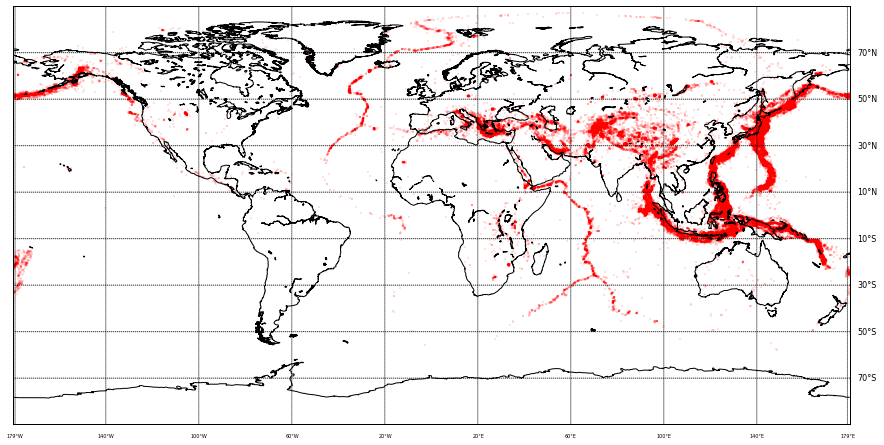

In [75]:
f = plt.figure(figsize=(15, 15))
ax = gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in sorted_idc[:, 2:]])
scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.1, s=6, marker=".", color="red")

In [76]:
def cluster_rpc(X, idxs, target_size, fixed_split=None):
    # given:
    #  global array X listing all points
    #  list of indices idxs
    #  target cluster size
    # return:
    #  list of indices corresponding to a partition of the indices into the target size


    n = len(idxs)
    if fixed_split is not None and len(fixed_split) == 0:
        return [idxs,], ()

    if fixed_split is None:
        if n < target_size:
            return [idxs,], ()

        idx1 = np.random.choice(idxs)
        idx2 = idx1
        while (idx2==idx1).all():
            idx2 = np.random.choice(idxs)


        x1 = X[idx1,:]
        x2 = X[idx2,:]

        # what's the projection of x3 onto (x1-x2)?
        # imagine that x2 is the origin, so it's just x3 onto x1.
        # This is x1 * <x3, x1>/||x1||
        cx1 = x1 - x2
        nx1 = cx1 / np.linalg.norm(cx1)
        fs1 = None
        fs2 = None
    else:
        (nx1, x2), fs1, fs2 = fixed_split

    if n > 0:
        alphas = [ np.dot(X[i,:]-x2, nx1)  for i in idxs]
        median = np.median(alphas)
        idxs1 = idxs[alphas < median]
        idxs2 = idxs[alphas >= median]
    else:
        idxs1 = ()
        idxs2 = ()
        
    L1, split1 = cluster_rpc(X, idxs1, target_size=target_size, fixed_split=fs1)
    L2, split2 = cluster_rpc(X, idxs2, target_size=target_size, fixed_split=fs2)

    split = ((nx1, x2), split1, split2)

    return L1 + L2, split

In [6]:

n = len(normed_locations)
all_idxs = np.arange(n)
cluster_idxs, splits = cluster_rpc(normed_locations, all_idxs, target_size=2000)

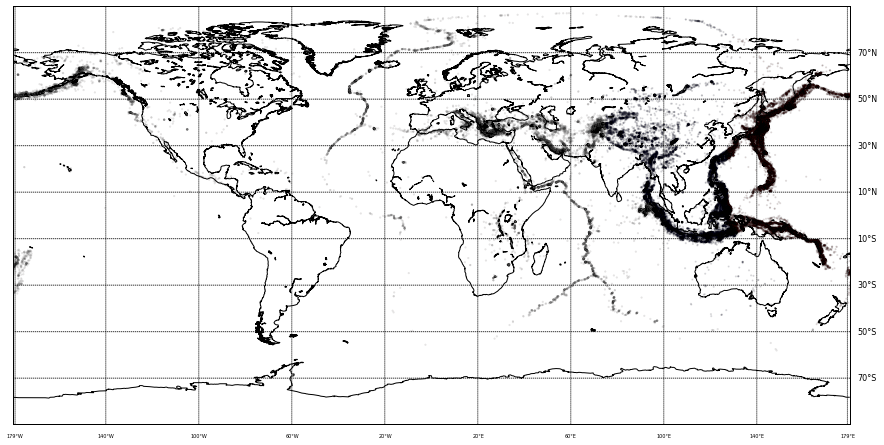

In [7]:
f = plt.figure(figsize=(15, 15))
ax = gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

yvals = np.zeros((n,))
#yvals[cluster_idxs[14]] = 0.5
yvals[:30000] = 0.5
yvals[60000:] = 1.0


normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in sorted_idc[:, 2:]])

scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.1, s=6, marker=".", c=yvals, cmap ="seismic")

In [8]:
from sigvisa.treegp.cover_tree import VectorTree
import pyublas

In [9]:

X = sorted_idc[:, (2, 3, 7)].copy()
ptree = VectorTree(X, 1, "lld", np.array((40.0,40.0)), "matern32", np.array((1.0,)))
ptree.dump_clusters("ctree.txt", 300)

In [10]:
centers = np.loadtxt("ctree.txt")
centers = np.asarray([c[:3] for c in centers if c[3]> 100])

In [24]:
clusters = np.argmin(dists, axis=1)

In [11]:

    

X = X[:, :2]
lons = X[:, 0] 
XX = X.copy() #X[60000:80000]

XX[:, 0]  = (lons + 22) % 360 - 22


In [12]:
# goal: provide dataset
# outcome: a random projection tree on indices.
# need to be able to:
#  - get list of clusters by idx: this can just be leaf nodes
#  - for a new X, recluster it
#  - draw the tree

class PDTree(object):
    
    class node(object):
        pass
    
    class leafnode(node):
        def __init__(self, idx):
            self.idx = idx
            self.children = len(idx)

    class innernode(node):
        def __init__(self, split_vec, center, split, left, right):
            self.split_vec = split_vec
            self.center = center
            self.split = split
            self.left = left
            self.right = right
            self.children = left.children+right.children
            
    def __init__(self, X, minsize):
        self.X = X
        idx = np.arange(len(X))
        self.tree = self.__build(idx, minsize)

        
    def __build(self, idx, minsize):
        n = len(idx)
        if n < minsize:
            return PDTree.leafnode(idx)
        
        
        data = self.X[idx]
        dmean = np.mean(data, axis=0)
        data -= dmean
        XXt = np.dot(data.T, data)
        ev, evec = np.linalg.eig(XXt)
        pidx = np.argmax(ev)
        pvec = evec[:, pidx]
        
        a = np.dot(data, pvec)
        split = np.median(a)
        
        idx1 = idx[a < split]
        idx2 = idx[a >= split]
        
        return PDTree.innernode(pvec, dmean, split, 
                    self.__build(idx1,minsize),
                    self.__build(idx2,minsize))

    def leaf_idx(self):
        
        def child_idxs(node):
            if isinstance(node, PDTree.leafnode):
                return [node.idx]
            else:
                leftidx = child_idxs(node.left)
                rightidx = child_idxs(node.right)
                return leftidx+rightidx
            
        return child_idxs(self.tree)
    
    def recluster(self, X):
        def recluster_recursive(node, idx):
            if isinstance(node, PDTree.leafnode):
                return [idx]
        
            data = X[idx]
            a = np.dot(data - node.center, node.split_vec)
            idx1 = idx[a < node.split]
            idx2 = idx[a >= node.split]
            return recluster_recursive(node.left, idx1) + recluster_recursive(node.right, idx2)
        
        idx = np.arange(len(X))
        return recluster_recursive(self.tree, idx)
    
    def draw_map(self, hm, maxdepth=None):
        
        def draw_recursive(node, idx, depth):
            if isinstance(node, PDTree.leafnode):
                return
            if depth > maxdepth:
                return
            
            data = self.X[idx]
            a = np.dot(data - node.center, node.split_vec)
            a_normal = np.array((-node.split_vec[1], node.split_vec[0]))
            
            r = np.dot(data - node.center, a_normal)
            d1 = np.min(r)
            d2 = np.max(r)
            medoid_idx = np.argmin(np.abs(a-node.split))
            medoid = data[medoid_idx, :]
            x1 = medoid + d1 * a_normal
            x2 = medoid + d2 * a_normal

            #x1 = data[i1,:]
            #x2 = data[i2,:]
            
            idx1 = idx[a < node.split]
            idx2 = idx[a >= node.split]
            
            
            hm.bmap.plot([x2[0], x1[0]], [x2[1], x1[1]], c="blue")
            
            
            draw_recursive(node.left, idx1, depth+1)
            draw_recursive(node.right, idx2, depth+1)
        

        idx = np.arange(len(self.X))
        return draw_recursive(self.tree, idx, 0)

In [13]:
t = PDTree(XX, minsize=410)
idxs = t.leaf_idx()
idx2 = t.recluster(XX)

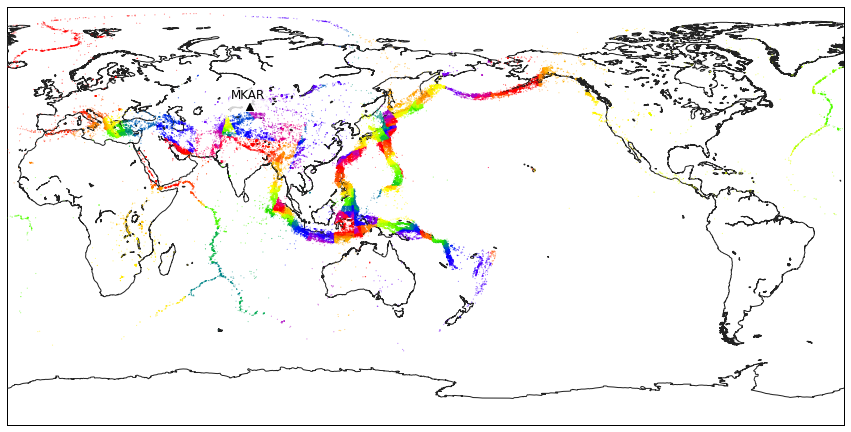

In [45]:
f = plt.figure(figsize=(15, 15))
ax = gca()
hm = EventHeatmap(f=None, left_lon=-22, right_lon=338, top_lat=89.9, bottom_lat=-89.9, calc=False)
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl", coastline_color="#222222")
#hm.plot_earth()

max_bounds = np.array((342, 90.0,))
min_bounds = np.array((-22.0, -90.0,))

ys = np.zeros((len(X)))
for i, cidx in enumerate(idxs):
    ys[cidx] = float(i)/len(idxs)

scplot = hm.bmap.scatter(XX[:, 0], XX[:, 1], alpha=0.5, s=5, marker=".", c=ys, cmap="prism",  lw = 0, zorder=18)

mkar = (82.2904, 46.7937)
scplot = hm.bmap.scatter([mkar[0],], [mkar[1],], alpha=1.0, s=50, marker="^", color="black", zorder=20)
ax.annotate(
    "MKAR",
    xy=mkar,
    xytext=(-18, 8),
    textcoords='offset points',
    size=12,
    zorder=20,
    color = 'black')

import matplotlib.patches as patches
ax.add_patch(
    patches.Rectangle(
        (73.2904, 44.7937),   # (x,y)
        17.0,          # width
        10.0,          # height
        facecolor="white",
        alpha=0.8,
        zorder=19,
        lw = 0,
        #edgecolor="red"
    ),
   
)

In [46]:
P = np.random.randn(3, 3)
K = np.dot(P, P.T)
L = np.linalg.cholesky(K)

eps = 1e-4
L2 = L.copy()
L2[0,0] += eps
K2= np.dot(L2, L2.T)
print (K2-K)/eps

[[ 2.22572968 -0.31171315  1.10807231]
 [-0.31171315  0.          0.        ]
 [ 1.10807231  0.          0.        ]]


In [229]:
eps = 1e-8
D = np.zeros(K.shape)
for i in range(3):
    for j in range(3):
        KK = K.copy()
        KK[i,j] += eps
        if i!=j:
            KK[j,i] += eps
        LL = np.linalg.cholesky(KK)
        D[i,j] = ((LL-L)/eps)[2,2]

print D

[[ 0.12061366 -0.41696255 -0.55988344]
 [-0.41696255  0.3603608   0.96776093]
 [-0.55988344  0.96776093  0.64973856]]


In [208]:
print L

[[ 2.19575669  0.          0.        ]
 [ 1.53455852  1.0090679   0.        ]
 [-0.1967853  -0.75148417  0.76954027]]


In [228]:
eps = 1e-4
L2 = L.copy()
L2[0,0] += eps
K2= np.dot(L2, L2.T)
print (K2-K)/eps

[[ 4.39161338  1.53455852 -0.1967853 ]
 [ 1.53455852  0.          0.        ]
 [-0.1967853   0.          0.        ]]


In [224]:
1.0/(L+L.T)

array([[ 0.22771193,  0.65165322, -5.08168034],
       [ 0.65165322,  0.49550679, -1.33070002],
       [-5.08168034, -1.33070002,  0.64973857]])

In [10]:
P = np.random.randn(1000, 1000)
A = np.dot(P, P.T) + np.eye(1000)*0.1

Y = np.random.randn(1000, 50)

alpha1 = np.linalg.solve(A, Y)

In [11]:
P2 = P + np.random.randn(1000, 1000)*0.001
A2 = np.dot(P2, P2.T)+ np.eye(1000)*0.1

In [71]:
import scipy.linalg
import time

def gauss_seidel(M, B, init_x=None):
    if init_x is None:
        X = np.ones((M.shape[1], B.shape[1]))
    else:
        X = init_x
    L = np.tril(M)
    U = np.triu(M, 1)
    #D = np.diag(np.diag(M))
    delta = 2
    norm = 100
    t0 = time.time()
    while norm > 0.01:
        target = B - np.dot(U, X)
        oldX = X
        X = scipy.linalg.solve_triangular(L, target, lower=True,overwrite_b=True)
        #X = 1.5*X - .5 * oldX
        
        norm = np.linalg.norm(np.dot(L, X) + np.dot(U, X) - B)
        print "norm", norm
        
        delta = np.sum((X-oldX)**2)
        tt = time.time()
        print "time", tt-t0, "delta", delta
    return X

def iterate(M, B, init_x=None):
    if init_x is None:
        init_x = np.ones((M.shape[1], B.shape[1]))
        
    def residual(x):
        X = x.reshape(init_x.shape)
        #r = np.dot(M, X) - B
        tmp2 = (np.dot(M, X).T - B.T)
        r = np.sum(tmp2 * tmp2)
        grad = np.dot((tmp2 + tmp2), M).flatten()
        print r
        return r, grad
    
    #x = init_x.flatten()
    #for i in range(15):
    #    r, grad = residual(x) 
    #    x = x - 0.00000001*grad
    
    x0 = init_x.flatten()
    
    rr = lambda x : residual(x)[0]

    
    r = scipy.optimize.minimize(residual, x0, jac=True, method="cg")
    print r
    return r.x.reshape(init_x.shape)

AA = np.array(((16, 3), (7, -11.0)))
b = np.array((11.0, 13)).reshape((-1, 1))

alpha_r1 = iterate(AA, b)

353.0
(353.0, array([  18.,  422.]))
353.0
353.00180305
353.0422013
[  18.0305  422.013 ]
> <ipython-input-71-232cc4f8b363>(55)iterate()
-> r = scipy.optimize.minimize(residual, x0, jac=True, method="cg")
(Pdb) quit


BdbQuit: 

<function scipy.optimize.optimize.check_grad>

In [26]:
t0 = time.time()
alpha1 = np.linalg.solve(A2, Y)
t1 = time.time()
print t1-t0

0.31867313385


In [31]:
print alpha1

[[-0.46328664 -1.59784078 -0.07307387 ...,  0.53520573  0.22739876
  -0.00948695]
 [-0.38322667 -0.04132164  0.48020441 ...,  0.27457823 -0.13785287
  -0.11620705]
 [ 0.24370872 -0.78623371  0.39420974 ...,  0.25021288  0.80816395
   0.65518955]
 ..., 
 [-0.15674154 -0.18083899  0.00879108 ...,  0.64443048 -0.28236957
   0.23602102]
 [-0.32277209  0.80705043  0.11934204 ..., -1.00940746 -0.88501735
  -0.19991699]
 [-0.9060793  -0.73027459 -0.39006846 ..., -0.74527264  0.23356079
   0.60836433]]


In [32]:
print alpha_g1

[[-0.2165947  -0.37760815 -0.17845299 ..., -0.0379589  -0.133066
  -0.18750313]
 [ 0.09931709  0.13682807  0.36529381 ...,  0.33943465  0.20795198
   0.23740236]
 [ 0.04494628 -0.0672703   0.22836263 ...,  0.09919819  0.20136977
   0.24676021]
 ..., 
 [-0.09473845 -0.07862056  0.03288644 ...,  0.10922695 -0.0826155
   0.06572274]
 [ 0.0086329   0.13425417  0.05770901 ..., -0.24158196  0.00913169
  -0.04061415]
 [ 0.0191947  -0.03053959  0.06065238 ...,  0.06630436 -0.00409165
   0.16279021]]


In [33]:
np.dot(A, alpha_g1)

array([[-0.02752867, -0.43718238,  1.21264117, ...,  0.45440288,
        -0.00399309,  0.13079868],
       [ 2.05555854,  0.55809522,  0.73846645, ..., -1.12294203,
         1.25610748, -1.75452444],
       [-1.84427705,  1.84449066,  1.34303336, ..., -0.97891123,
        -1.64456742, -0.12648401],
       ..., 
       [ 1.28494095, -0.02934904,  0.01665464, ..., -0.57786301,
        -0.59931655,  1.12590854],
       [-0.68465908,  1.79188769,  0.02136641, ..., -0.17724963,
         0.02093444,  0.18047353],
       [ 2.33087706,  0.32449762, -1.16959431, ...,  1.50219512,
        -0.59252049, -1.23447827]])

In [34]:
print Y

[[-0.15450531 -0.84193495  1.23437301 ...,  0.75485258  0.13019677
   0.19419864]
 [ 1.22915186 -0.12409819  0.42237232 ..., -1.56987271  0.54879857
  -2.41649498]
 [-1.97708103  1.398953    1.41675311 ..., -1.07085158 -1.57698475
  -0.15706979]
 ..., 
 [ 1.23726612 -0.08761439 -0.02948625 ..., -0.60460143 -0.63402733
   1.09816015]
 [-0.65971827  1.81795024  0.04119561 ..., -0.15744913  0.03804421
   0.19013412]
 [ 2.33087706  0.32449762 -1.16959431 ...,  1.50219512 -0.59252049
  -1.23447827]]


In [41]:
np.linalg.norm(Y)

223.48065571257669

In [70]:
import scipy.stats
def gp_lik(d, od):
    K = np.ones((3,3)) * d * od
    K += np.eye(3) * (d*(1-od))
    y = np.array((0.9, 1.0, 1.1))
    rv=scipy.stats.multivariate_normal(cov=K)
    return rv.logpdf(y)

def gprf_lik(d, od):
    y = np.array((0.9, 1.0, 1.1))
    unary_rv = scipy.stats.norm(scale=np.sqrt(d))
    unary_lls = unary_rv.logpdf(y)
    
    K = np.ones((2,2)) * d * od
    K += np.eye(2) * (d*(1-od))
    pair_rv = scipy.stats.multivariate_normal(cov=K)
    y1 = np.array((0.9, 1.0))
    y2 = np.array((0.9, 1.1))
    y3 = np.array((1.0, 1.1))
    ll = pair_rv.logpdf(y1) + pair_rv.logpdf(y2) + pair_rv.logpdf(y3)
    ll -= np.sum(unary_lls)
    
    print "discrepancy", pair_rv.logpdf(y1) - unary_lls[0] - unary_lls[1]
    
    return ll



lls1 = np.zeros((20,20))
lls2 = np.zeros((20,20))
ds = (0.5, 1.0, 2.0, 5.0, 100.0)
ods = (0.01, 0.1, 0.5, 0.9, 0.99, 0.9999, 0.99999)
for i, d in enumerate(ds):
    for j, od in enumerate(ods):
        ll1 = gprf_lik(d, od)
        ll2 = gp_lik(d, od)
        print d, od, ll1, ll2
        lls1[i,j] = ll1
        lls2[i,j] = ll2

discrepancy 0.0178707845784
0.5 0.01 -4.67774290108 -4.67832429736
discrepancy 0.168560521462
0.5 0.1 -4.17898902196 -4.22511731374
discrepancy 0.740507702893
0.5 0.5 -2.33223838676 -2.91052123849
discrepancy 1.64036560341
0.5 0.9 0.330844086722 -1.2007480158
discrepancy 2.36148259775
0.5 0.99 1.15835798959 -0.664597702441
discrepancy -44.8339235309
0.5 0.9999 -288.926380297 -194.056093936
discrepancy -493.68261287
0.5 0.99999 -2985.47243492 -1991.75347863
discrepancy 0.00896039353927
1.0 0.01 -4.23706463202 -4.2373558228
discrepancy 0.0867928446944
1.0 0.1 -3.98022494432 -4.00372697346
discrepancy 0.442174369559
1.0 0.5 -2.84862582427 -3.18024200933
discrepancy 1.23536560341
1.0 0.9 -0.48729773675 -1.60475450092
discrepancy 2.16000018569
1.0 0.99 1.61868747001 -0.200962768583
discrepancy -20.2876509673
1.0 0.9999 -139.973525939 -94.595781372
discrepancy -244.136360614
1.0 0.99999 -1486.51964818 -992.293196171
discrepancy 0.00450519801972
2.0 0.01 -4.53658588291 -4.53673197095
discrepa

In [87]:
n = np.load("/home/dmoore/python/gprf/neighbors_107556_60_0.005_20.000.npy")
X = np.load("/home/dmoore/python/gprf/XX.npy")
import cPickle as pickle
with open("/home/dmoore/python/gprf/idxs.pkl", "rb") as f:
    idxs = pickle.load(f)
bad_blocks =  [69, 70, 71, 72, 74, 75, 76, 77]

bad_idxs = [idxs[b] for b in bad_blocks]
badX = X[np.concatenate(bad_idxs), :]

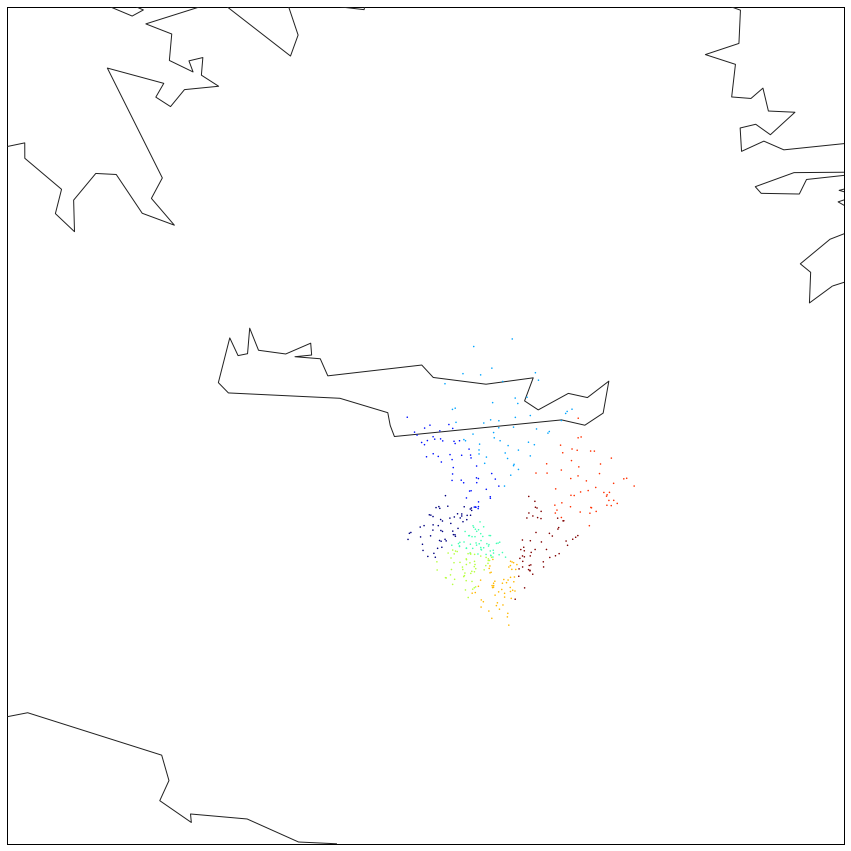

In [96]:
f = plt.figure(figsize=(15, 15))
ax = gca()
hm = EventHeatmap(f=None, left_lon=22, right_lon=28, top_lat=38, bottom_lat=32, calc=False)
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl", coastline_color="#222222")
#hm.plot_earth()

max_bounds = np.array((342, 90.0,))
min_bounds = np.array((-22.0, -90.0,))

ys = np.zeros((len(badX)))
c = 0
for i, cidx in enumerate(bad_idxs):
    cnew = c + len(cidx)
    ys[c:cnew] = c / float(len(badX))
    c = cnew
    
scplot = hm.bmap.scatter(badX[:, 0], badX[:, 1], alpha=1.0, s=10, marker=".", c=ys, cmap="jet",  lw = 0, zorder=18)

